<a href="https://colab.research.google.com/github/hyeonu96/first-repository/blob/main/%5BEX_04%5D%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%A3%BC%EC%8B%9D_%EC%98%88%EC%B8%A1%EC%97%90_%EB%8F%84%EC%A0%84%ED%95%B4_%EB%B3%B4%EC%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

프로젝트 : 주식 예측에 도전해 보자

STEP 1 : 시계열 데이터 준비

*   칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
*   날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
*   우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandas
import sklearn
import statsmodels
from matplotlib.pylab import rcParams

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

dataset_filepath ='/content/sample_data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

1.3.5
1.0.2
0.12.2


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

STEP 2 : 각종 전처리 수행

*   결측치 처리
*   로그 변환



In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [4]:
# 로그 변환 시도 
ts_log = np.log(ts)

STEP 3 : 시계열 안정성 분석

*   정성적 그래프 분석
*   정량적 Augmented Dicky-Fuller Test
*   시계열 분해(Time Series Decomposition)
*   Residual 안정성 확인



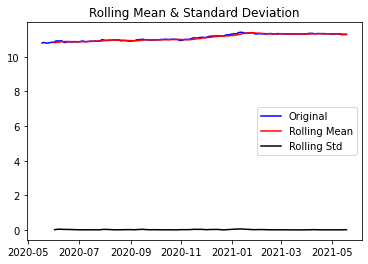

In [10]:
# 일정 시간 내 구간 통계치(Rolling Statistics) 시각화하는 함수
def plot_rolling_statistics(ts_log, window=12):
    rolmean = ts_log.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = ts_log.rolling(window=window).std()    # 이동표준편차 시계열
    
     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(ts_log, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(ts_log, window=12)

In [12]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


STEP 4 : 학습, 테스트 데이터셋 생성

*   학습, 테스트 데이터셋 분리



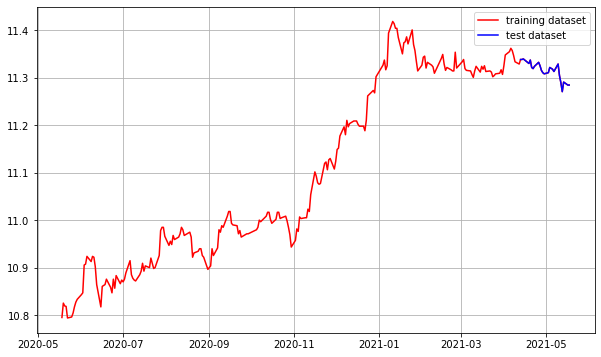

In [13]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


STEP 5 : 적정 ARIMA 모수 찾기

*   ACF, PACF 그려보기 -> p,q 구하기
*   차분 안정성 확인 -> d 구하기



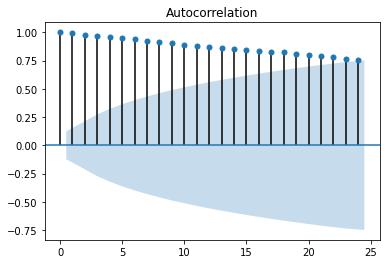

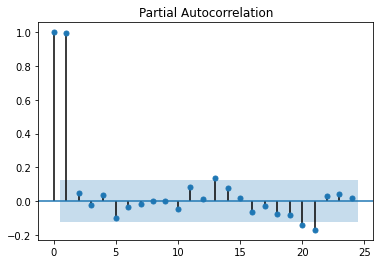

In [14]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


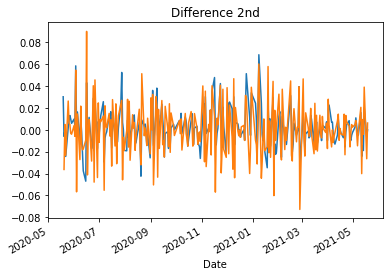

In [15]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

STEP 6 : ARIMA 모델 훈련과 테스트


*   ARIMA 모델 빌드와 훈련
*   모델 테스트 및 플로팅
*   최종 예측 모델 정확도 측정(MAPE)



In [16]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Fri, 30 Sep 2022   AIC                          -1156.722
Time:                        01:51:42   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


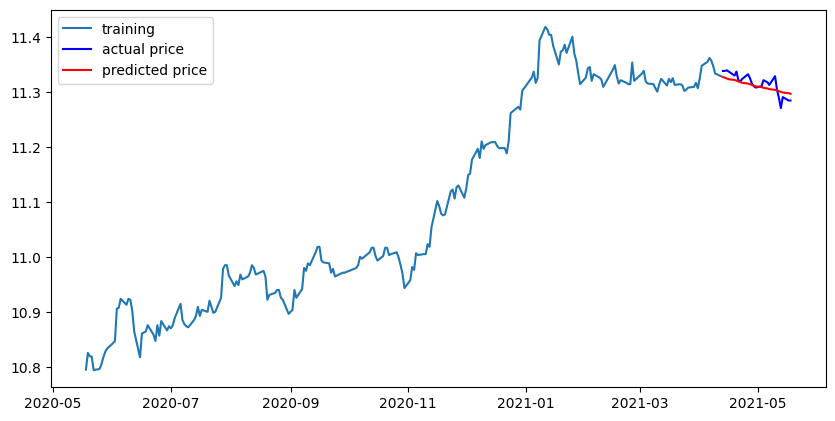

In [17]:

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [18]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  1048973.6014240584
MAE:  843.7579531509296
RMSE:  1024.194122920093
MAPE: 1.03%


STEP 7 : 다른 주식 종목 예측해 보기

*   관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandas
import sklearn
import statsmodels
from matplotlib.pylab import rcParams

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

dataset_filepath ='/content/sample_data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

1.3.5
1.0.2
0.12.2


Date
2021-09-29    142.830002
2021-09-30    141.500000
2021-10-01    142.649994
2021-10-04    139.139999
2021-10-05    141.110001
Name: Close, dtype: float64

In [23]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 
ts.head()

Date
2021-09-29    142.830002
2021-09-30    141.500000
2021-10-01    142.649994
2021-10-04    139.139999
2021-10-05    141.110001
Name: Close, dtype: float64

In [24]:
# 로그 변환 시도 
ts_log = np.log(ts)

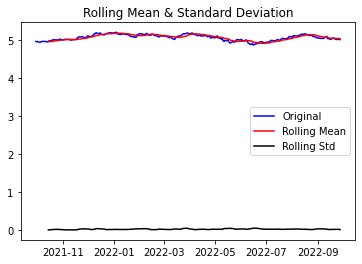

In [27]:
# 일정 시간 내 구간 통계치(Rolling Statistics) 시각화하는 함수
def plot_rolling_statistics(ts_log, window=12):
    rolmean = ts_log.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = ts_log.rolling(window=window).std()    # 이동표준편차 시계열
    
     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(ts_log, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(ts_log, window=12)

In [28]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.163789
p-value                          0.219649
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


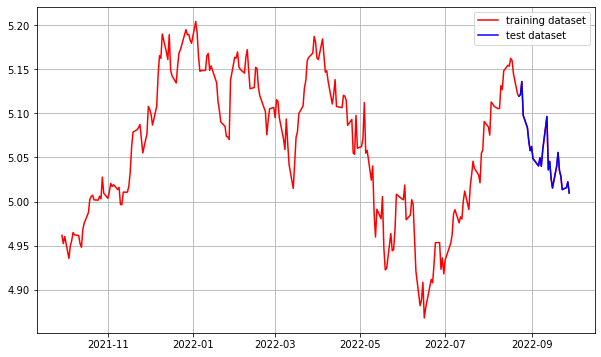

In [29]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


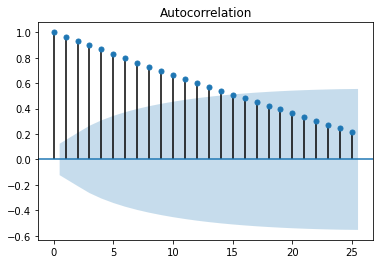

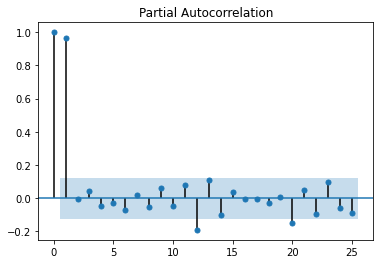

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.605511e+01
p-value                        5.718543e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.956005e+00
p-value                        3.036156e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


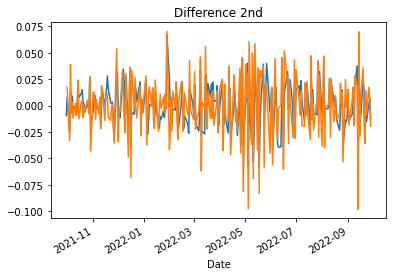

In [31]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [32]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 567.588
Date:                Fri, 30 Sep 2022   AIC                          -1125.176
Time:                        02:06:36   BIC                          -1108.073
Sample:                             0   HQIC                         -1118.274
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0598      0.303     16.689      0.000       4.466       5.654
ar.L1          0.1288      0.055      2.335      0.020       0.021       0.237
ar.L2          0.8632      0.056     15.379      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


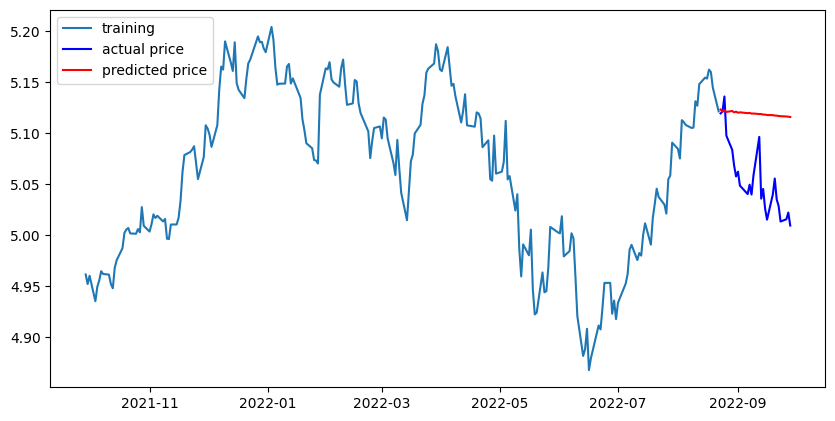

In [34]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  133.5218091354732
MAE:  10.494223947049871
RMSE:  11.555163743343199
MAPE: 6.80%


회고

APPLE 회사의 주식데이터를 불러와서 예측해보았다.

시계열 데이터준비 -> 각종 전처리 수행 -> 시계열 안정성 분석 -> 학습, 테스트 데이터셋 생성 ->적정 ARIMA 모수찾기 -> ARIMA 모델 훈련과 테스트

이와 같은 순서로 작업을 2번 진행 해보았다.
시계열 안정성 분석 부분에서 에러코드가 많이 떴고 해결하기 위해 많은 검색을 요구했다. 예시 코드와는 달리 세세한 부분을 설정해 주어야지만 작동이 되는 모습이었다.


삼성

MSE:  1048973.6014240584
/ MAE:  843.7579531509296
/ RMSE:  1024.194122920093
/ MAPE: 1.03%

APPLE

MSE:  133.5218091354732
/ MAE:  10.494223947049871
/ RMSE:  11.555163743343199
/ MAPE: 6.80%

이러한 데이터 값을 확인해 볼 수 있었다.